# Task 4 - Proxy Target Variable Engineering

This notebook creates a credit risk target variable using RFM (Recency, Frequency, Monetary) analysis and K-Means clustering.

**Objective:** Identify "disengaged" customers and label them as high-risk proxies.

**Steps:**
1. Calculate RFM metrics for each customer.
2. Cluster customers using K-Means (3 groups).
3. Analyze clusters and assign `is_high_risk` label.
4. Merge target into the processed feature dataset.

## 1. Setup and Imports

In [1]:
import sys
from pathlib import Path

# Add src to path
PROJECT_ROOT = Path.cwd().parent
sys.path.insert(0, str(PROJECT_ROOT / "src"))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from data_processing import get_raw_data_path, load_raw_data
from feature_engineering import add_time_features
from target_engineering import (
    compute_rfm,
    cluster_rfm,
    analyze_clusters,
    assign_high_risk,
    build_modeling_dataset,
)

# Plot settings
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

print("Imports successful.")

Imports successful.


## 2. Load Data

In [2]:
# Load raw transaction data
data_path = get_raw_data_path()
df_raw = load_raw_data(data_path)
print(f"Raw transactions: {df_raw.shape}")

# Add time features
df_txn = add_time_features(df_raw)
print(f"Transactions with time features: {df_txn.shape}")

Raw transactions: (95662, 16)
Transactions with time features: (95662, 23)


In [3]:
# Load customer features from Task 3
features_path = PROJECT_ROOT / "data" / "processed" / "customer_features.csv"
df_features = pd.read_csv(features_path)
print(f"Customer features: {df_features.shape}")
df_features.head()

Customer features: (3742, 24)


,CustomerId,txn_count,total_amount,avg_amount,std_amount,min_amount,max_amount,total_value,avg_value,avg_txn_hour,...,n_debits,productcategory_financial_services_ratio,productcategory_airtime_ratio,productcategory_utility_bill_ratio,channelid_channelid_3_ratio,channelid_channelid_2_ratio,channelid_channelid_5_ratio,providerid_providerid_4_ratio,providerid_providerid_6_ratio,providerid_providerid_5_ratio
0,CustomerId_1,1,-10000.0,-10000.000000,0.000000,-10000.0,-10000.0,10000,10000.000000,16.000000,...,0,0.000000,1.000000,0.0,0.000000,1.000000,0.0,1.000000,0.0,0.000000
1,CustomerId_10,1,-10000.0,-10000.000000,0.000000,-10000.0,-10000.0,10000,10000.000000,16.000000,...,0,0.000000,1.000000,0.0,0.000000,1.000000,0.0,1.000000,0.0,0.000000
2,CustomerId_1001,5,20000.0,4000.000000,6558.963333,-5000.0,10000.0,30400,6080.000000,7.800000,...,3,0.600000,0.400000,0.0,0.600000,0.400000,0.0,0.400000,0.4,0.200000
3,CustomerId_1002,11,4225.0,384.090909,560.498966,-75.0,1500.0,4775,434.090909,13.454545,...,5,0.545455,0.454545,0.0,0.454545,0.545455,0.0,0.545455,0.0,0.454545
4,CustomerId_1003,6,20000.0,3333.333333,6030.478146,-5000.0,10000.0,32000,5333.333333,14.333333,...,4,0.500000,0.500000,0.0,0.666667,0.333333,0.0,0.333333,0.5,0.166667


## 3. Calculate RFM Metrics

For each `CustomerId`, calculate:
- **Recency**: Days since last transaction (from snapshot date).
- **Frequency**: Number of transactions.
- **Monetary**: Sum of transaction values.

In [4]:
# Define snapshot date
snapshot_date = df_txn["txn_datetime"].max() + pd.Timedelta(days=1)
print(f"Snapshot date: {snapshot_date}")

# Compute RFM
df_rfm = compute_rfm(df_txn, snapshot_date=snapshot_date)
print(f"\nRFM table shape: {df_rfm.shape}")
df_rfm.head(10)

Snapshot date: 2019-02-14 10:01:28+00:00

RFM table shape: (3742, 4)


,CustomerId,recency_days,frequency,monetary
0,CustomerId_1,84,1,10000
1,CustomerId_10,84,1,10000
2,CustomerId_1001,90,5,30400
3,CustomerId_1002,26,11,4775
4,CustomerId_1003,12,6,32000
5,CustomerId_1004,53,1,2000
6,CustomerId_1005,47,9,61200
7,CustomerId_1006,65,1,1000
8,CustomerId_1007,82,1,28000
9,CustomerId_1008,66,2,20000


In [5]:
# RFM summary statistics
df_rfm[["recency_days", "frequency", "monetary"]].describe()

,recency_days,frequency,monetary
count,3742.000000,3742.000000,3.742000e+03
mean,31.461251,25.564404,2.531025e+05
std,27.118932,96.929602,2.715877e+06
min,1.000000,1.000000,5.000000e+01
25%,6.000000,2.000000,6.500000e+03
50%,25.000000,7.000000,3.200000e+04
75%,54.000000,20.000000,1.020600e+05
max,91.000000,4091.000000,1.049000e+08


**Observation**: 
- Recency ranges from 1 day to several months, indicating varying customer engagement levels.
- Frequency and Monetary are right-skewed, with most customers having few transactions and a few power users with many.

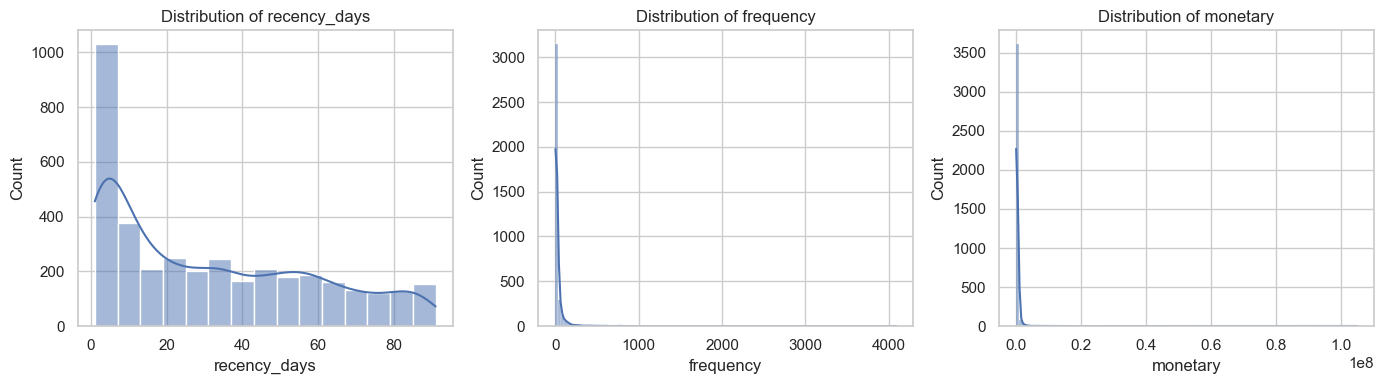

In [6]:
# Visualize RFM distributions
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for ax, col in zip(axes, ["recency_days", "frequency", "monetary"]):
    sns.histplot(df_rfm[col], ax=ax, kde=True)
    ax.set_title(f"Distribution of {col}")
    ax.set_xlabel(col)

plt.tight_layout()
plt.show()

## 4. Cluster Customers using K-Means

Segment customers into 3 groups based on their RFM profiles.

**Preprocessing:** Scale RFM features before clustering.

In [7]:
# Cluster RFM (3 clusters, fixed random_state for reproducibility)
df_rfm_clustered, scaler, kmeans = cluster_rfm(df_rfm, n_clusters=3, random_state=42)

print(f"Cluster labels added. Shape: {df_rfm_clustered.shape}")
print(f"\nCluster distribution:")
print(df_rfm_clustered["rfm_cluster"].value_counts().sort_index())

Cluster labels added. Shape: (3742, 5)

Cluster distribution:
rfm_cluster
0    1426
1    2312
2       4
Name: count, dtype: int64


In [8]:
# Cluster centers (scaled)
print("Cluster centers (scaled):")
cluster_centers_scaled = pd.DataFrame(
    kmeans.cluster_centers_,
    columns=["recency_days", "frequency", "monetary"]
)
cluster_centers_scaled.index.name = "cluster"
cluster_centers_scaled

Cluster centers (scaled):


,recency_days,frequency,monetary
cluster,,,
0,1.121086,-0.184052,-0.060159
1,-0.691726,0.094380,-0.010418
2,-0.302827,11.132613,27.480428


## 5. Analyze Clusters

Compute mean RFM metrics per cluster to understand each segment.

In [9]:
# Cluster summary (unscaled values)
cluster_summary = analyze_clusters(df_rfm_clustered)
cluster_summary

,rfm_cluster,recency_days,frequency,monetary,customer_count
0,0,61.877279,7.720196,8.973793e+04,1426
1,1,12.715398,34.703720,2.247565e+05,2312
2,2,23.250000,1104.500000,7.487659e+07,4


/var/folders/gg/27pw2x014vsd1k85_8h2d6rm0000gn/T/ipykernel_26545/2675952629.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="rfm_cluster", y=col, data=cluster_summary, ax=ax, palette="viridis")
/var/folders/gg/27pw2x014vsd1k85_8h2d6rm0000gn/T/ipykernel_26545/2675952629.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="rfm_cluster", y=col, data=cluster_summary, ax=ax, palette="viridis")
/var/folders/gg/27pw2x014vsd1k85_8h2d6rm0000gn/T/ipykernel_26545/2675952629.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="rfm_cluster", y=

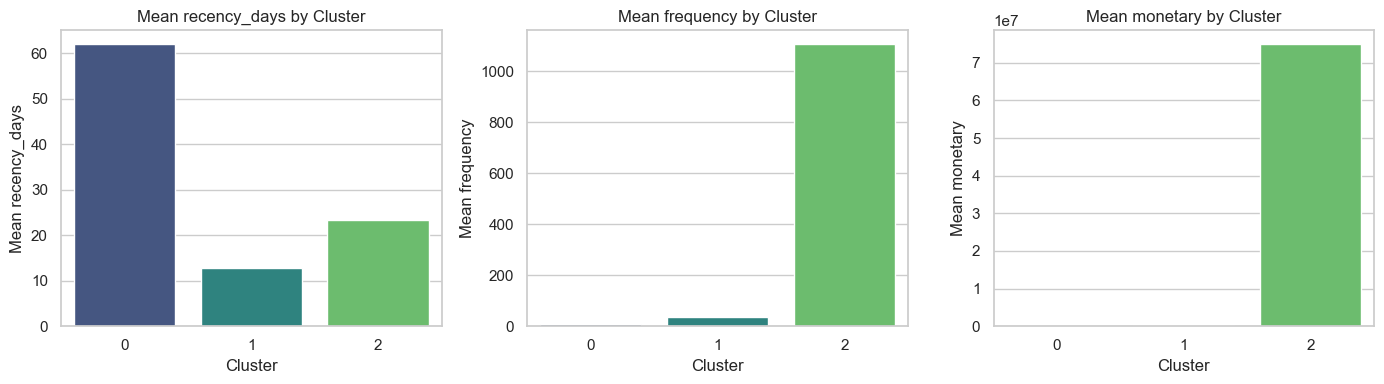

In [10]:
# Visualize cluster profiles
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for ax, col in zip(axes, ["recency_days", "frequency", "monetary"]):
    sns.barplot(x="rfm_cluster", y=col, data=cluster_summary, ax=ax, palette="viridis")
    ax.set_title(f"Mean {col} by Cluster")
    ax.set_xlabel("Cluster")
    ax.set_ylabel(f"Mean {col}")

plt.tight_layout()
plt.show()

**Observation**: 
- Look for the cluster with **high recency** (not transacting recently), **low frequency**, and **low monetary** value.
- This cluster represents the **least engaged / highest-risk** customers.

## 6. Define and Assign "High-Risk" Label

Use a scoring approach to identify the high-risk cluster:
- High recency (bad)
- Low frequency (bad)
- Low monetary (bad)

In [11]:
# Assign high-risk label
df_rfm_with_target, high_risk_cluster, cluster_analysis = assign_high_risk(df_rfm_clustered)

print(f"High-risk cluster identified: {high_risk_cluster}")
print(f"\nCluster analysis with risk scores:")
cluster_analysis

High-risk cluster identified: 0

Cluster analysis with risk scores:


,rfm_cluster,recency_days,frequency,monetary,customer_count,recency_rank,frequency_rank,monetary_rank,risk_score
0,0,61.877279,7.720196,8.973793e+04,1426,3.0,3.0,3.0,9.0
1,1,12.715398,34.703720,2.247565e+05,2312,1.0,2.0,2.0,5.0
2,2,23.250000,1104.500000,7.487659e+07,4,2.0,1.0,1.0,4.0


In [12]:
# Target distribution
print("Target distribution (is_high_risk):")
target_dist = df_rfm_with_target["is_high_risk"].value_counts()
print(target_dist)
print(f"\nHigh-risk rate: {target_dist[1] / len(df_rfm_with_target) * 100:.2f}%")

Target distribution (is_high_risk):
is_high_risk
0    2316
1    1426
Name: count, dtype: int64

High-risk rate: 38.11%


/var/folders/gg/27pw2x014vsd1k85_8h2d6rm0000gn/T/ipykernel_26545/2602862484.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="is_high_risk", data=df_rfm_with_target, palette="coolwarm", ax=ax)


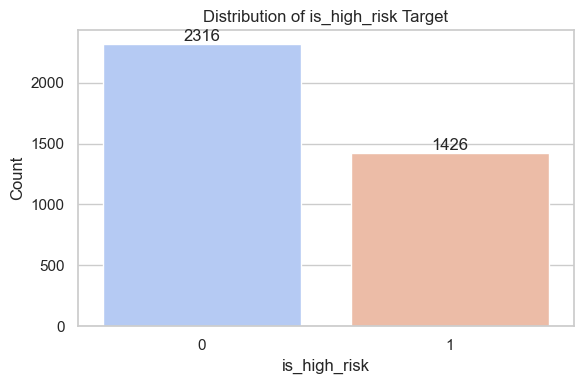

In [13]:
# Visualize target distribution
fig, ax = plt.subplots(figsize=(6, 4))
sns.countplot(x="is_high_risk", data=df_rfm_with_target, palette="coolwarm", ax=ax)
ax.set_title("Distribution of is_high_risk Target")
ax.set_xlabel("is_high_risk")
ax.set_ylabel("Count")
for p in ax.patches:
    ax.annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha="center", va="bottom", fontsize=12)
plt.tight_layout()
plt.show()

**Observation**: 
- The high-risk cluster contains customers who are less engaged.
- This is our **proxy target** for credit risk modeling.

## 7. Integrate Target into Processed Dataset

Merge `is_high_risk` and RFM metrics into the customer feature table from Task 3.

In [14]:
# Build modeling dataset
df_model = build_modeling_dataset(df_features, df_rfm_with_target)

print(f"Modeling dataset shape: {df_model.shape}")
print(f"\nColumns ({len(df_model.columns)}):")
print(df_model.columns.tolist())

Modeling dataset shape: (3742, 29)

Columns (29):
['CustomerId', 'txn_count', 'total_amount', 'avg_amount', 'std_amount', 'min_amount', 'max_amount', 'total_value', 'avg_value', 'avg_txn_hour', 'std_txn_hour', 'weekend_txn_ratio', 'net_amount', 'n_credits', 'n_debits', 'productcategory_financial_services_ratio', 'productcategory_airtime_ratio', 'productcategory_utility_bill_ratio', 'channelid_channelid_3_ratio', 'channelid_channelid_2_ratio', 'channelid_channelid_5_ratio', 'providerid_providerid_4_ratio', 'providerid_providerid_6_ratio', 'providerid_providerid_5_ratio', 'recency_days', 'frequency', 'monetary', 'rfm_cluster', 'is_high_risk']


In [15]:
df_model.head(10)

,CustomerId,txn_count,total_amount,avg_amount,std_amount,min_amount,max_amount,total_value,avg_value,avg_txn_hour,...,channelid_channelid_2_ratio,channelid_channelid_5_ratio,providerid_providerid_4_ratio,providerid_providerid_6_ratio,providerid_providerid_5_ratio,recency_days,frequency,monetary,rfm_cluster,is_high_risk
0,CustomerId_1,1,-10000.0,-10000.000000,0.000000,-10000.0,-10000.0,10000,10000.000000,16.000000,...,1.000000,0.0,1.000000,0.000000,0.000000,84,1,10000,0,1
1,CustomerId_10,1,-10000.0,-10000.000000,0.000000,-10000.0,-10000.0,10000,10000.000000,16.000000,...,1.000000,0.0,1.000000,0.000000,0.000000,84,1,10000,0,1
2,CustomerId_1001,5,20000.0,4000.000000,6558.963333,-5000.0,10000.0,30400,6080.000000,7.800000,...,0.400000,0.0,0.400000,0.400000,0.200000,90,5,30400,0,1
3,CustomerId_1002,11,4225.0,384.090909,560.498966,-75.0,1500.0,4775,434.090909,13.454545,...,0.545455,0.0,0.545455,0.000000,0.454545,26,11,4775,1,0
4,CustomerId_1003,6,20000.0,3333.333333,6030.478146,-5000.0,10000.0,32000,5333.333333,14.333333,...,0.333333,0.0,0.333333,0.500000,0.166667,12,6,32000,1,0
5,CustomerId_1004,1,2000.0,2000.000000,0.000000,2000.0,2000.0,2000,2000.000000,18.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,53,1,2000,0,1
6,CustomerId_1005,9,48800.0,5422.222222,5983.681513,-5000.0,10000.0,61200,6800.000000,10.111111,...,0.333333,0.0,0.333333,0.333333,0.333333,47,9,61200,0,1
7,CustomerId_1006,1,1000.0,1000.000000,0.000000,1000.0,1000.0,1000,1000.000000,7.000000,...,0.000000,0.0,0.000000,0.000000,1.000000,65,1,1000,0,1
8,CustomerId_1007,1,28000.0,28000.000000,0.000000,28000.0,28000.0,28000,28000.000000,6.000000,...,0.000000,0.0,0.000000,0.000000,1.000000,82,1,28000,0,1
9,CustomerId_1008,2,20000.0,10000.000000,0.000000,10000.0,10000.0,20000,10000.000000,13.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,66,2,20000,0,1


In [16]:
# Verify target is present
print("Target distribution in modeling dataset:")
print(df_model["is_high_risk"].value_counts())

Target distribution in modeling dataset:
is_high_risk
0    2316
1    1426
Name: count, dtype: int64


## 8. Save Modeling Dataset

In [17]:
# Save to processed folder
output_path = PROJECT_ROOT / "data" / "processed" / "customer_features_with_target.csv"
df_model.to_csv(output_path, index=False)

print(f"Saved modeling dataset to: {output_path}")
print(f"Shape: {df_model.shape}")

Saved modeling dataset to: /Users/macbookpro/Documents/Credit-Risk-Probability-Model/data/processed/customer_features_with_target.csv
Shape: (3742, 29)


## 9. Summary

### What We Did

1. **Calculated RFM Metrics** for each customer:
   - Recency: days since last transaction
   - Frequency: number of transactions
   - Monetary: sum of transaction values

2. **Clustered Customers** using K-Means (3 clusters) on scaled RFM features.

3. **Identified High-Risk Cluster** based on:
   - High recency (inactive customers)
   - Low frequency (few transactions)
   - Low monetary value (low spending)

4. **Created Binary Target** `is_high_risk`:
   - 1 = high-risk cluster
   - 0 = other clusters

5. **Merged Target** into customer features for model training.

### Proxy Target Limitations

**Important:** This is a **proxy** for credit risk, not actual default data.

- We are labeling customers as "high-risk" based on behavioral disengagement (low RFM).
- This assumes that disengaged customers are more likely to default, which may not always hold.
- For production use, this model should be validated against real loan performance data.

### Next Steps (Task 5)

1. Train classification models (Logistic Regression, Random Forest, etc.).
2. Evaluate models using accuracy, precision, recall, F1, ROC-AUC.
3. Track experiments with MLflow.
4. Compute real WoE/IV with the actual `is_high_risk` target.